# <b><font color='darkred'>Analyse der Vorhersagefehler mit SVR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn import model_selection, svm, preprocessing
from sklearn.decomposition import PCA
import helper

/Users/melanie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
pca = False      # PCA Anwendung ja oder nein?

SCALE = 2000    # Skalierung für Zielvariable Zugfestigkeit


STATS = [
    # Power (p_*)
    "p_mean", "p_median", "p_std", "p_max", "p_q25", "p_q75", 
    "p_iqr_range", "p_f_ratio", "p_d_ratio", "p_t_ratio",
    
    # Force (f_*)
    #"f_mean", "f_median", "f_std", "f_max", "f_q25", "f_q75", 
    "f_iqr_range", "f_d_ratio", "f_t_ratio",
    
    # Distance (d_*)
    "d_mean", "d_median", "d_std", "d_max", "d_q25", "d_q75", 
    "d_iqr_range", "d_t_ratio", 'd_b75',
    
    # Zeitmerkmale
    "t_max",
]

# 🏆
STATS = ['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25', 'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio', 't_max', 'p_std', 'd_std']

In [3]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data() # random_state=42

In [4]:
stat_feat = helper.StatFeatures(STATS)
stat_feat.fit()

StatFeatures(columns=['p_max', 'p_q75', 'p_median', 'p_f_ratio', 'p_q25',
                      'p_d_ratio', 'p_t_ratio', 'f_t_ratio', 'f_d_ratio',
                      't_max', 'p_std', 'd_std'])

In [5]:
X_train = stat_feat.transform(versuche_train.key, kurven)
X_test  = stat_feat.transform(versuche_test.key,  kurven)

print(X_train.shape, X_test.shape) 

(480, 12) (120, 12)


In [6]:
label_train      = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values

label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

<b><font color='lightgreen'> Skalieren Trainings- und Testdaten mit PCA

In [7]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled  = std_scaler.transform(X_test)

festigkeit_test  = festigkeit_test/SCALE
festigkeit_train = festigkeit_train/SCALE

In [8]:
if pca == True:
    pca_scaler = PCA(n_components=0.98)
    X_train_scaled = pca_scaler.fit_transform(X_train_scaled)
    X_test_scaled  = pca_scaler.transform(X_test_scaled)
    
    pca_scaler.n_components_, pca_scaler.explained_variance_ratio_

<b><font color='lightgreen'> Kontrollanzeige t-SNE

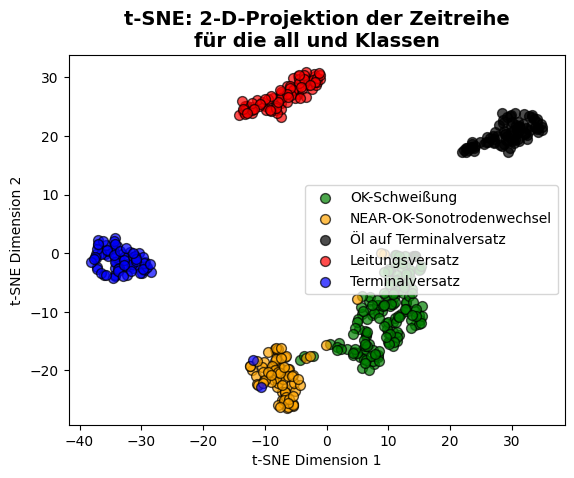

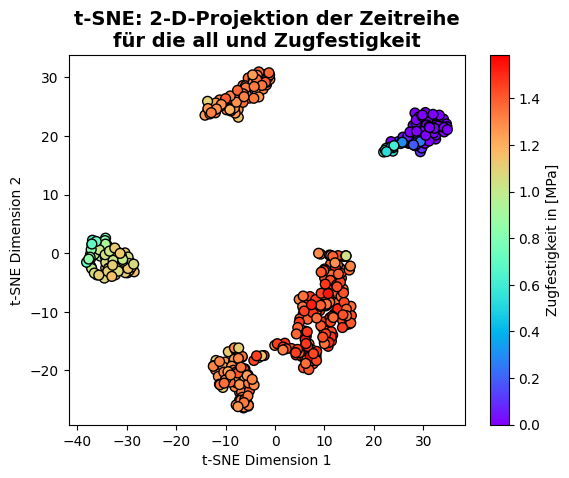

In [9]:
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Klassen')
helper.plotTSNE(X_train_scaled, festigkeit_train, label_train, 'all', 'Zugfestigkeit')

<b><font color='lightgreen'><h3> SVR - Support Vector Regression (Hyperparameter Random Search) </b>

In [10]:
params = {
    'C':       np.logspace( 0, 4), 
    'epsilon': np.logspace(-2, 2), 
    'gamma':   np.logspace(-5, 1), 
    #'kernel': ['rbf', 'linear'],
}
estimator_regr = model_selection.RandomizedSearchCV(
    svm.SVR(),
    params,
    n_iter=500,
    n_jobs=-1
)
estimator_regr.fit(X_train_scaled, festigkeit_train)
best_estimator = estimator_regr.best_estimator_

# Vorhersage
y_pred_train = best_estimator.predict(X_train_scaled)
y_pred_test  = best_estimator.predict(X_test_scaled)

best_estimator

SVR(C=75.43120063354615, epsilon=0.025595479226995357,
    gamma=0.03556480306223129)

<b><font color='lightgreen'> Modellbewertung</b>

In [11]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,11474.06,10680.76
RMSE,107.12,103.35
MAE,77.81,73.69
R²,0.99,0.99


<b><font color='lightgreen'> Vorhersage Trainings- & Testdaten

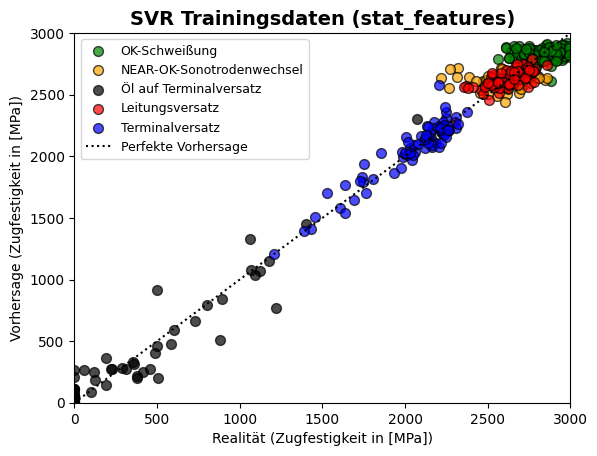

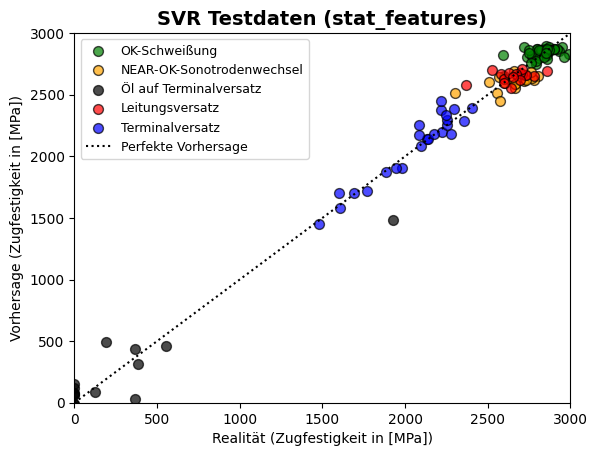

In [12]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'SVR Trainingsdaten (stat_features)', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'SVR Testdaten (stat_features)', 'mit Linie', SCALE)

<b><font color='lightgreen'> Analyse der Ergebnisse der Vorhersage

In [13]:
# Ergebnisse der Trainingsdaten
result_train = versuche_train[['key', 'label', 'festigkeit']].copy()
result_train['pred']    = y_pred_train*SCALE
result_train['abs_err'] = (result_train.festigkeit - result_train.pred).abs()
for (i, col) in enumerate(STATS):
    result_train[col] = X_train_scaled[:, i]
res_train_sorted = result_train.sort_values('abs_err', ascending=False)

# Ergebnisse der Testdaten
result_test = versuche_test[['key', 'label', 'festigkeit']].copy()
result_test['pred'] = y_pred_test*SCALE
result_test['abs_err'] = (result_test.festigkeit - result_test.pred).abs()
for (i, col) in enumerate(STATS):
    result_test[col] = X_test_scaled[:, i]
res_test_sorted = result_test.sort_values('abs_err', ascending=False)
res_test_sorted

,key,label,festigkeit,pred,abs_err,p_max,p_q75,p_median,p_f_ratio,p_q25,p_d_ratio,p_t_ratio,f_t_ratio,f_d_ratio,t_max,p_std,d_std
9,fehler_oel_2057,2,1930.000000,1481.225345,448.774655,0.985777,1.086965,1.190025,1.136562,1.281984,0.931917,1.106675,1.254846,0.632992,-1.291023,0.533981,-0.634645
69,fehler_oel_2024,2,364.000000,32.828069,331.171931,2.266902,2.282925,2.332994,2.268853,2.312083,1.996884,2.345307,2.202804,1.160233,-1.954651,1.852037,-1.034714
93,fehler_oel_2008,2,193.000000,496.273146,303.273146,1.708750,1.726391,1.839250,1.822344,1.863972,1.605045,1.769920,1.724336,1.011982,-1.684010,1.279261,-0.955846
6,ok_1579,0,2590.000000,2823.940398,233.940398,-0.050838,-0.106673,-0.065672,0.207268,0.045995,0.321505,-0.053110,-0.118867,0.516132,-0.234409,-0.551833,-0.557769
25,fehler_terminversatz_2449,4,2219.936523,2447.663817,227.727293,-0.574703,-0.655481,-0.637861,-0.507150,-0.536889,-0.214462,-0.544761,-0.574092,0.255372,0.495952,-0.901395,-0.190420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,ok_1651,0,2850.000000,2845.919026,4.080974,-0.311949,-0.276253,-0.264815,-0.131371,-0.197221,-0.088518,-0.243599,-0.223360,0.098985,0.017695,-0.651143,-0.389543
90,near_ok_sonowechsel_2964,1,2627.864746,2630.041952,2.177206,-0.136075,-0.327173,-0.297442,-0.281522,-0.194895,0.306636,-0.264058,-0.126434,1.049216,0.047355,-0.614311,-0.622326
105,fehler_leitungsversatz_2544,3,2670.678955,2672.165440,1.486485,-0.619551,-0.487138,-0.468502,-0.814092,-0.666163,-1.351196,-0.754899,-0.812009,-1.912924,0.903768,1.208133,1.929421
78,fehler_terminversatz_2469,4,2141.172852,2142.622095,1.449244,-0.856062,-0.920519,-0.956583,-0.847224,-0.874063,-0.509057,-0.781730,-0.850497,0.012359,0.963087,-1.031550,0.089818


In [14]:
# Kleinste Vorhersagefehler Training
res_train_good = res_train_sorted.tail(20)
res_train_good.head(5)

,key,label,festigkeit,pred,abs_err,p_max,p_q75,p_median,p_f_ratio,p_q25,p_d_ratio,p_t_ratio,f_t_ratio,f_d_ratio,t_max,p_std,d_std
443,fehler_terminversatz_2495,4,1387.555664,1392.004618,4.448954,-0.423024,-0.962214,-1.151415,-0.922301,-1.094316,-0.777171,-0.852807,-0.967160,-0.512736,1.122506,-0.827726,0.916575
328,fehler_oel_2034,2,286.000000,281.738496,4.261504,1.955054,2.046494,2.188642,2.069057,2.221201,1.735877,2.127032,2.057330,0.979966,-1.858258,1.568102,-0.896342
208,fehler_leitungsversatz_2514,3,2645.829834,2649.372741,3.542907,-0.656292,-0.518566,-0.525717,-0.779606,-0.673139,-1.311065,-0.740301,-0.806786,-1.849082,0.874109,0.775689,1.513135
369,near_ok_sonowechsel_2942,1,2650.239258,2653.718391,3.479134,-0.352807,-0.392678,-0.372741,-0.357071,-0.273182,-0.061946,-0.329143,-0.203922,0.397538,0.143747,-0.647141,-0.522969
376,fehler_leitungsversatz_2516,3,2666.104980,2662.675704,3.429277,-0.662629,-0.520390,-0.521265,-0.841304,-0.726913,-1.348388,-0.774929,-0.838351,-1.886311,0.948257,0.957413,1.746462


In [15]:
# Größte Vorhersagefehler Training
res_train_bad = res_train_sorted.head(20)
res_train_bad.head(5)

,key,label,festigkeit,pred,abs_err,p_max,p_q75,p_median,p_f_ratio,p_q25,p_d_ratio,p_t_ratio,f_t_ratio,f_d_ratio,t_max,p_std,d_std
390,fehler_oel_2086,2,1220.000000,772.369896,447.630104,1.459481,1.542377,1.635982,1.536794,1.646795,1.542512,1.558065,1.649064,1.181961,-1.569080,0.998161,-0.877499
267,near_ok_sonowechsel_2948,1,2273.802246,2705.435636,431.633390,-0.296949,-0.362313,-0.323101,-0.291737,-0.215654,-0.246520,-0.297225,-0.193169,-0.046036,0.095551,-0.599330,-0.283657
471,near_ok_sonowechsel_2943,1,2214.447510,2639.699345,425.251835,-0.411418,-0.462893,-0.436761,-0.392048,-0.339696,-0.309226,-0.391924,-0.317743,-0.067761,0.240140,-0.686962,-0.235716
49,fehler_oel_2068,2,499.000000,915.341553,416.341553,1.217252,1.322463,1.342220,1.277074,1.246135,1.181877,1.231901,1.340348,0.887540,-1.372587,0.790923,-0.915597
88,near_ok_sonowechsel_2978,1,2317.215088,2717.459042,400.243954,-0.331941,-0.354868,-0.315084,-0.314897,-0.213256,-0.165130,-0.292500,-0.159650,0.141983,0.088136,-0.622784,-0.243602


In [16]:
# Fehler kleiner 0 (nicht möglich) 
res_train_sorted[res_train_sorted['pred'] < 0]

,key,label,festigkeit,pred,abs_err,p_max,p_q75,p_median,p_f_ratio,p_q25,p_d_ratio,p_t_ratio,f_t_ratio,f_d_ratio,t_max,p_std,d_std
103,fehler_oel_2009,2,0.0,-51.659570,51.659570,2.396477,2.168996,1.658029,1.758322,1.119719,2.153469,1.757219,1.764929,1.845418,-1.676595,1.799579,-1.405149
295,fehler_oel_2025,2,0.0,-51.107666,51.107666,2.481778,2.330633,2.160163,2.127572,1.904786,1.981506,2.219423,2.144990,1.261363,-1.899040,1.901317,-1.182146
433,fehler_oel_2047,2,0.0,-51.039864,51.039864,2.487838,2.448751,2.450569,2.387022,2.419509,2.025385,2.551574,2.401104,1.098846,-2.039922,1.987046,-1.068923
2,fehler_oel_2083,2,0.0,-50.816172,50.816172,2.506123,2.350080,2.163262,2.162349,2.051427,2.022692,2.295507,2.229184,1.286185,-1.932407,1.863059,-1.060873
214,fehler_oel_2011,2,0.0,-50.803033,50.803033,2.434177,2.255035,1.952397,2.008397,1.658518,1.886206,2.048838,1.992740,1.237167,-1.821184,1.808101,-1.245809
406,fehler_oel_2087,2,0.0,-50.651996,50.651996,2.680055,2.558816,2.364643,2.333722,2.123222,1.888027,2.505072,2.382779,0.963377,-2.021385,2.069544,-1.024119
353,fehler_oel_2100,2,0.0,-43.939244,43.939244,2.491465,2.441827,2.273869,2.254220,2.156019,2.023066,2.407661,2.312105,1.207261,-1.980603,1.967855,-1.130079
192,fehler_oel_2054,2,0.0,-40.090867,40.090867,2.367801,2.257053,1.988706,2.023293,1.798281,1.781596,2.113412,2.080228,1.081240,-1.850844,1.769653,-1.178425
32,fehler_oel_2061,2,0.0,-39.384613,39.384613,2.595414,2.449532,2.338331,2.306556,2.236316,2.268269,2.445209,2.318472,1.484898,-1.995433,2.020517,-1.141845
434,fehler_oel_2053,2,0.0,-36.212330,36.212330,2.437186,2.445560,2.588676,2.465211,2.606674,1.988300,2.607553,2.409343,0.987309,-2.062166,2.050279,-0.949079


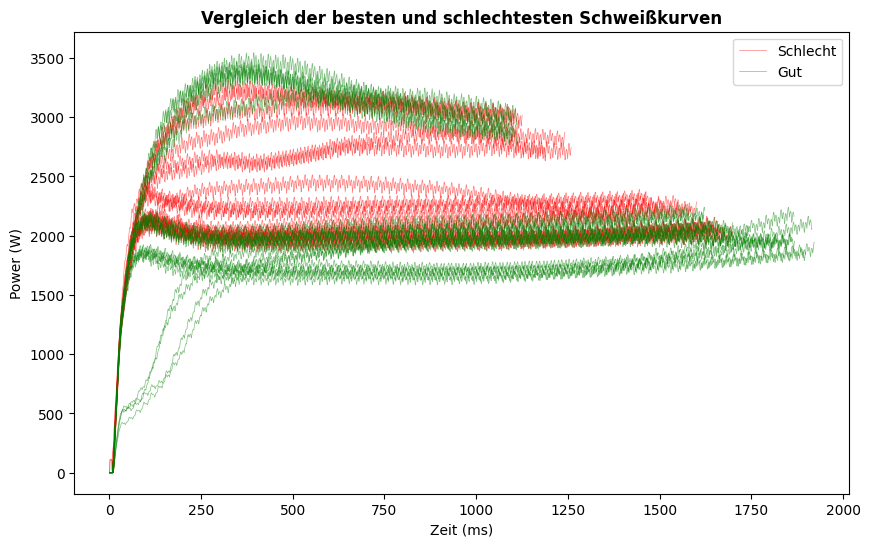

In [17]:
plt.figure(figsize=(10, 6))

# Schlechte Kurven (rot)
for i in range(len(res_train_bad)):
    key = res_train_bad.key.iloc[i]
    c = kurven[key]
    plt.plot(c.ms, c.power, linewidth=0.5, alpha=0.5, color='red', label="Schlecht" if i == 0 else "")

# Gute Kurven (grün)
for i in range(len(res_train_good)):
    key = res_train_good.key.iloc[i]
    c = kurven[key]
    plt.plot(c.ms, c.power, linewidth=0.5, alpha=0.5, color='green', label="Gut" if i == 0 else "")

plt.xlabel("Zeit (ms)")
plt.ylabel("Power (W)")
plt.title("Vergleich der besten und schlechtesten Schweißkurven", weight='bold')
plt.legend()
plt.show()

In [18]:
X_df = pd.DataFrame(X_train_scaled, columns=STATS)
X_df['festigkeit'] = festigkeit_train
X_df['label'] = label_train
X_df

,p_max,p_q75,p_median,p_f_ratio,p_q25,p_d_ratio,p_t_ratio,f_t_ratio,f_d_ratio,t_max,p_std,d_std,festigkeit,label
0,-0.088453,0.026638,0.088143,0.121191,0.205837,0.432491,0.062188,0.205544,0.812999,-0.371584,-0.422553,-0.216473,1.375000,0
1,-0.015356,0.047323,0.093293,0.326888,0.187550,0.389835,0.075118,0.040367,0.515126,-0.386413,-0.438926,-0.384150,1.385000,0
2,2.506123,2.350080,2.163262,2.162349,2.051427,2.022692,2.295507,2.229184,1.286185,-1.932407,1.863059,-1.060873,0.000000,2
3,-0.963190,-0.975172,-1.004592,-0.906020,-0.923961,-0.574687,-0.823880,-0.905805,-0.067145,1.055772,-1.054588,0.164818,1.085483,4
4,-0.063426,-0.049915,-0.010415,0.069601,0.085671,0.160793,-0.016446,0.086369,0.364126,-0.278898,-0.465636,-0.352512,1.420000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-0.186727,-0.132306,-0.099581,0.047939,-0.007003,0.039837,-0.094803,-0.062557,0.160155,-0.182505,-0.566044,-0.461549,1.365000,0
476,-0.058177,-0.065781,-0.056606,0.066510,0.025842,0.028743,-0.049589,0.017797,0.120697,-0.238117,-0.468920,-0.263710,1.455000,0
477,-0.415493,-0.447157,-0.464680,-0.482788,-0.398290,0.052769,-0.404349,-0.258636,0.784327,0.258677,-0.688630,-0.700498,1.262634,1
478,-0.538474,-0.382824,-0.350788,-0.612797,-0.334609,-1.278124,-0.611900,-0.639574,-1.899015,0.618297,0.966985,1.817291,1.329825,3


In [19]:
print("Häufigkeiten der schlechtesten Vorhersagen nach Klassen")
grp_res = pd.DataFrame(res_train_bad.label.value_counts()).reset_index()
grp_res.columns = ['label', 'count_err']
tmp = pd.DataFrame(versuche_train.label.value_counts()).reset_index()
grp_res = grp_res.merge(tmp, on='label', how='left')
grp_res['ratio'] = grp_res['count_err'] / grp_res['count']
grp_res.set_index('label')

Häufigkeiten der schlechtesten Vorhersagen nach Klassen


,count_err,count,ratio
label,,,
2,7,83,0.084337
1,6,81,0.074074
0,6,157,0.038217
4,1,76,0.013158


<b><font color='lightgreen'> Analyse der Vorhersageergebnisse - ohne Betrachtung der Klassen

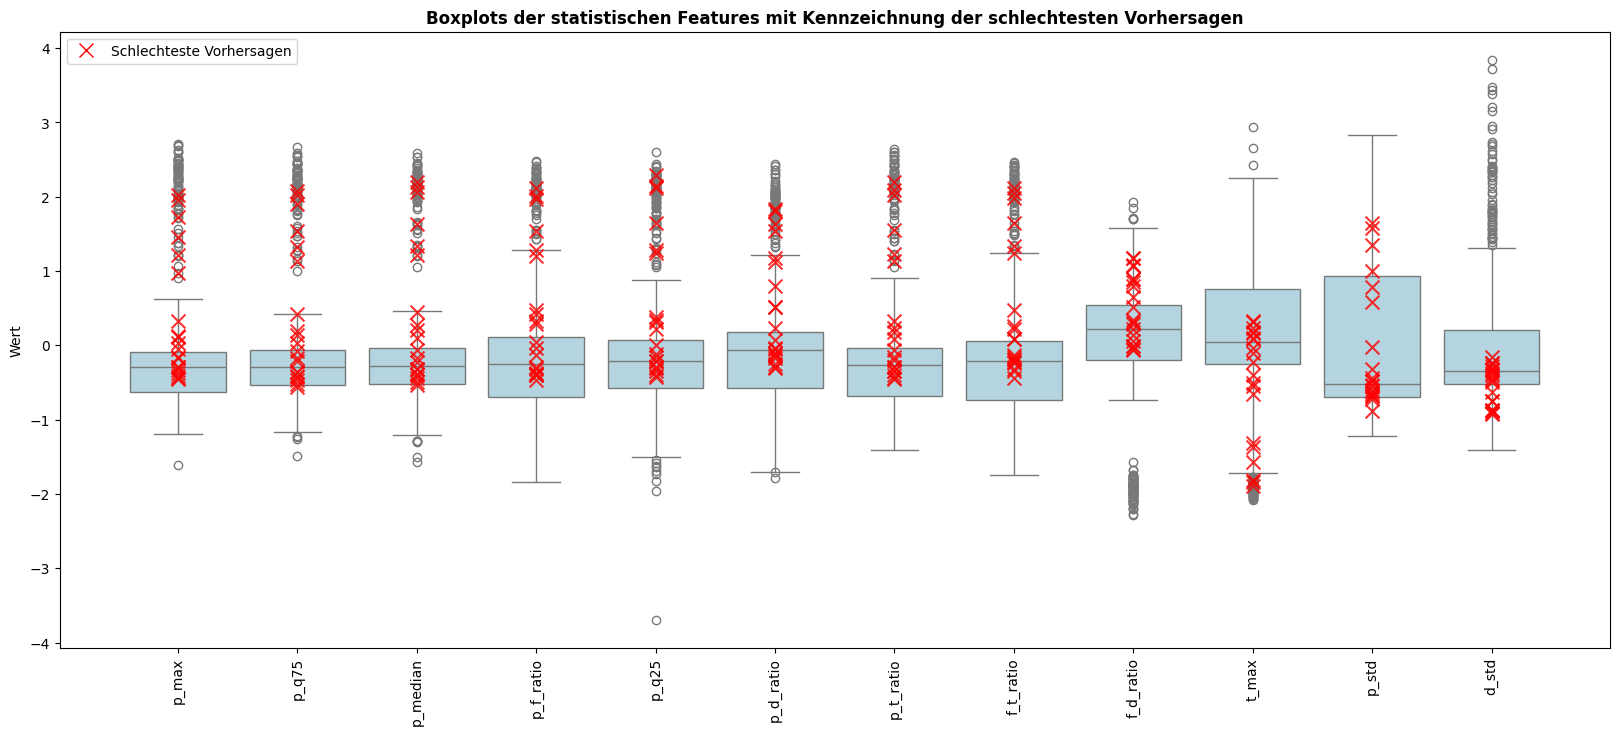

In [20]:
feature_cols = [col for col in X_df.columns if col not in ("label","festigkeit")]
X_df_melted = X_df.melt(value_vars=feature_cols)

plt.figure(figsize=(20, 8))
ax = sns.boxplot(data=X_df_melted, x="variable", y="value", showfliers=True, color='lightblue')

# Schlechteste Schweißungen 
X_bad = X_df.loc[res_train_bad.index] 

# Punkte für schlechteste Schweißungen in der richtigen Klasse einfügen
for i, row in X_bad.iterrows():
    for feature in feature_cols:
        value = row[feature]
        x_pos = feature_cols.index(feature)  
        plt.scatter(x_pos, value, color="red", alpha=0.8, marker="x", s=100, zorder=3)

plt.xticks(rotation=90)
plt.title("Boxplots der statistischen Features mit Kennzeichnung der schlechtesten Vorhersagen", weight='bold')
plt.ylabel("Wert")
plt.xlabel(" ")
legend_marker = Line2D([0], [0], color="red", marker="x", linestyle="None", markersize=10, label="Schlechteste Vorhersagen")
plt.legend(handles=[legend_marker])
plt.show()


<b><font color='lightgreen'> Analyse der Vorhersageergebnisse - Betrachtung der Klassen & Zugfestigkeiten <br><br>
</b>Trainingsdaten

In [21]:
label_mapping = {
    0: "OK-Schweißung",
    1: "NEAR-OK-Sonotrodenwechsel",
    2: "Öl auf Terminalversatz",
    3: "Leitungsversatz",
    4: "Terminalversatz"
}
color_mapping = {
    0: "green",
    1: "orange",
    2: "black",
    3: "red",
    4: "blue"
}

def boxplot_by_label(df, label, points):
    fig, ax = plt.subplots()
    # Boxplot der Features
    err_max = points['abs_err'].max()
    err_min = points['abs_err'].min()
    err_range = err_max-err_min
    df.loc[df.label == label].iloc[:,5:].plot(kind='box', title='label {}'.format(label), figsize=(15,8), ax=ax, color=color_mapping[label])
    sel_points = points.loc[points.label==label]
    # Statistische Features der Ausreißer als Punkte ergänzt
    cmap = plt.colormaps['rainbow']
    colors = cmap(np.linspace(0, 1, len(sel_points)))
    for ci, (_, row) in enumerate(sel_points.iterrows()):
        plt.scatter(np.arange(1, len(STATS)+1), row[5:], color=cmap((row['abs_err']-err_min)/err_range))
    plt.colorbar(plt.cm.ScalarMappable(norm= matplotlib.colors.Normalize(vmin=err_min, vmax=err_max), cmap=cmap), ax=ax)  
    plt.xticks(rotation=90)
    plt.title("Statistische Features und schlechteste Vorhersagen\nfür die Klasse "+str(label)+" = "+label_mapping[label], weight="bold")
    plt.show()   

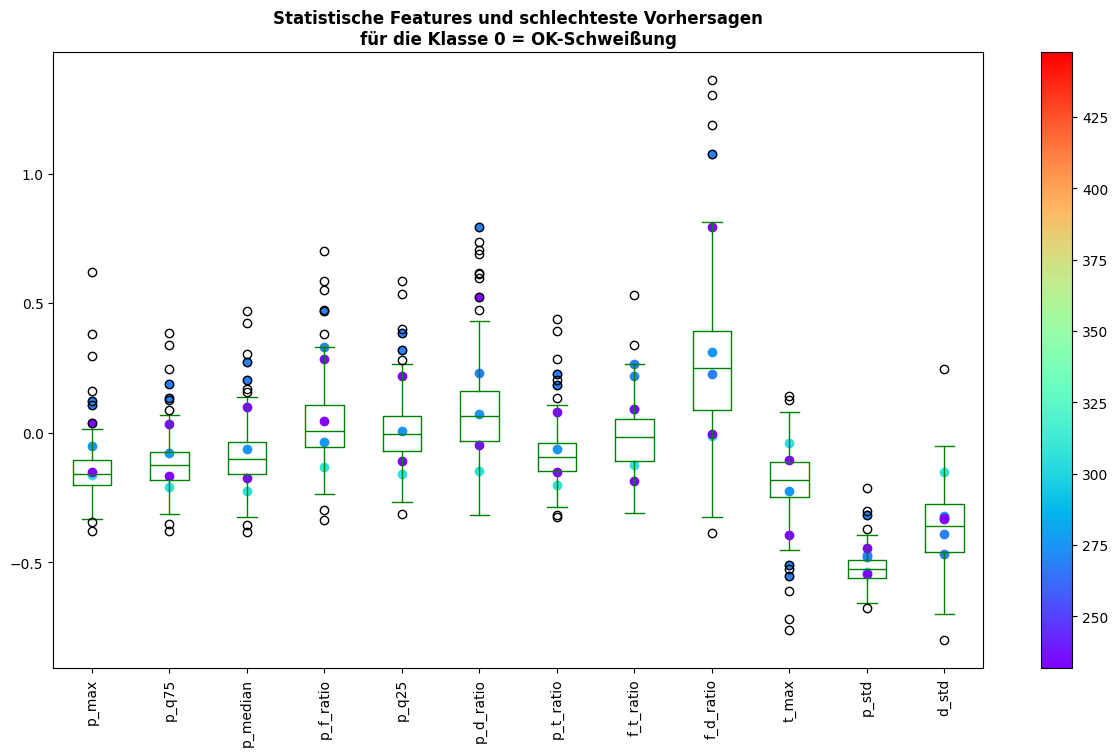

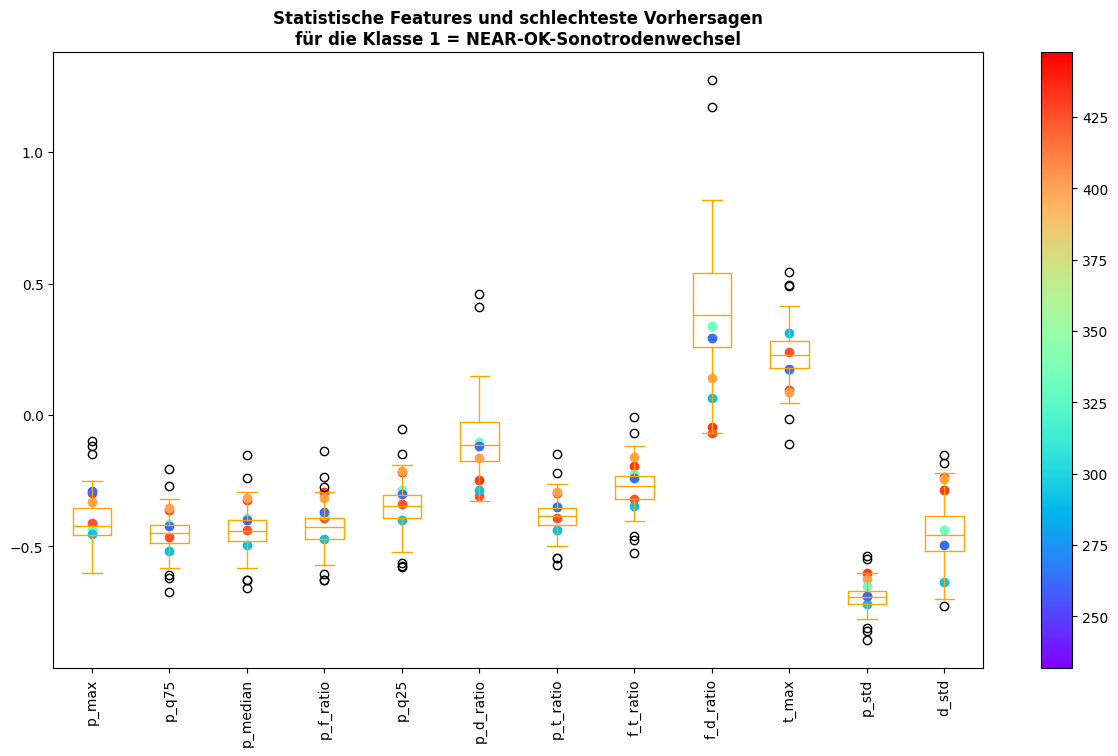

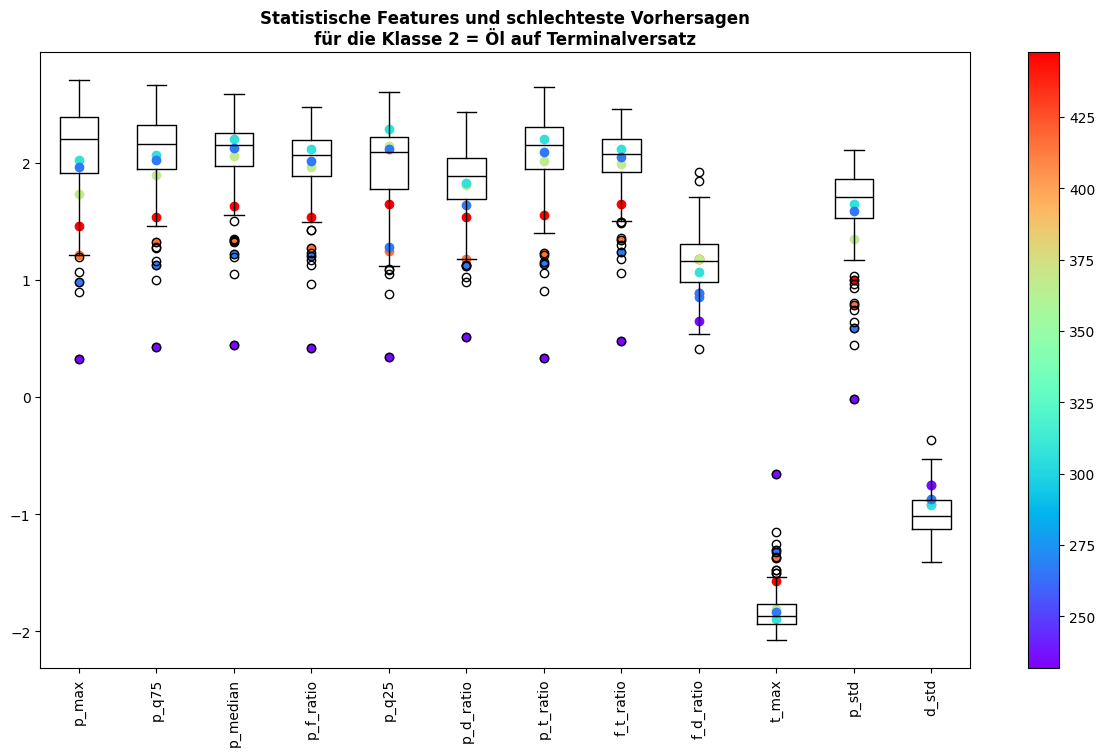

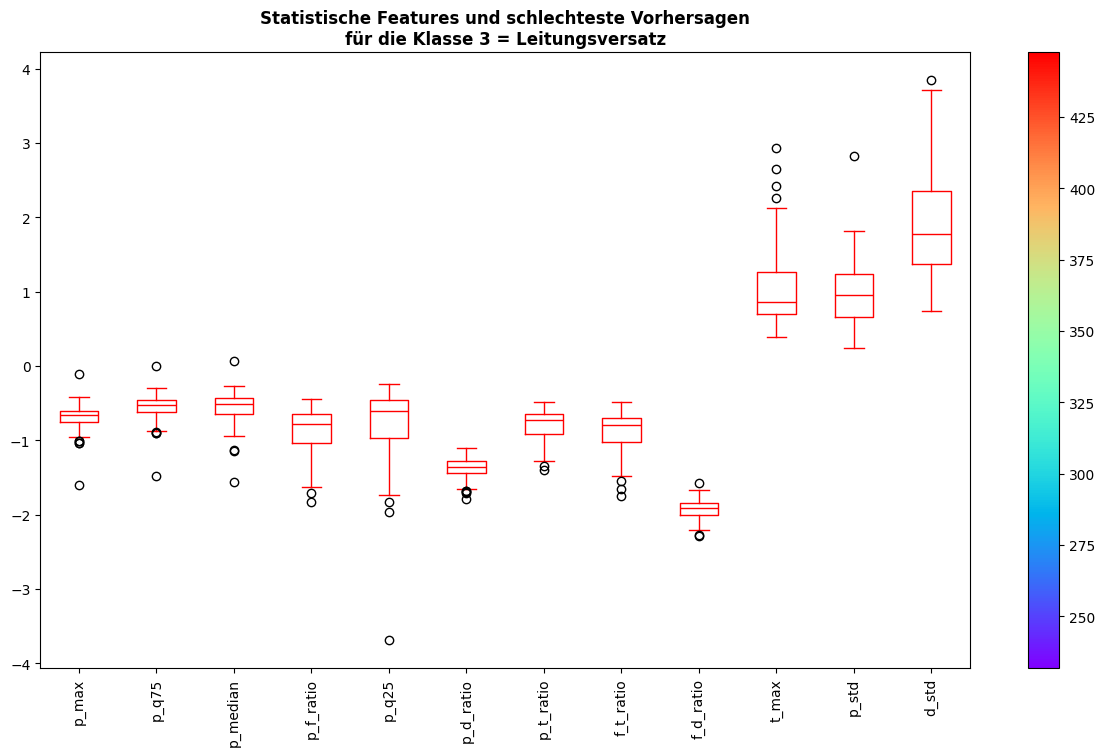

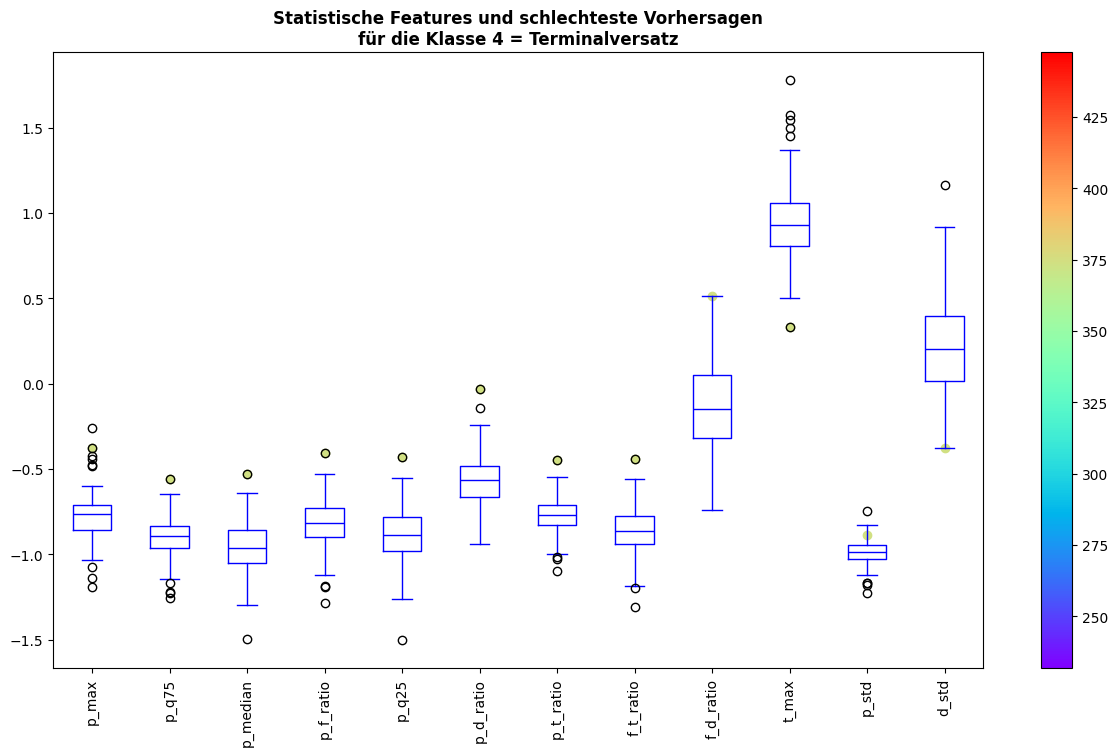

In [22]:
for label in range(5):
    boxplot_by_label(result_train, label, res_train_sorted.head(20))

<font color='lightgreen'>Testdaten

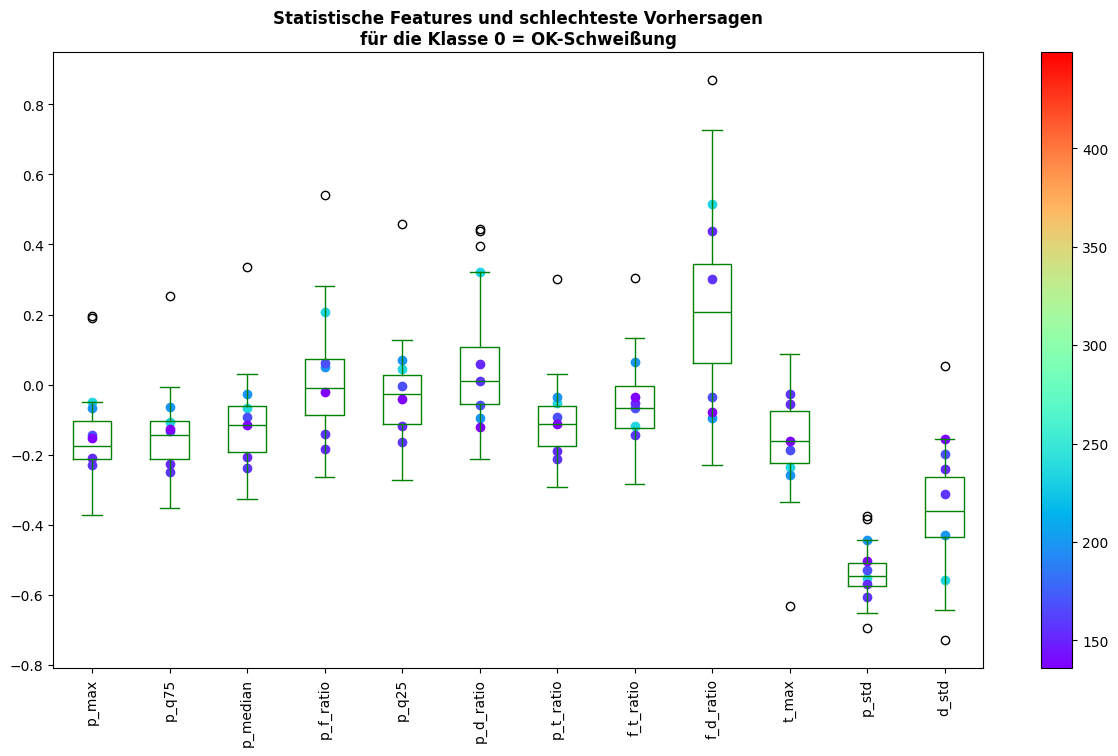

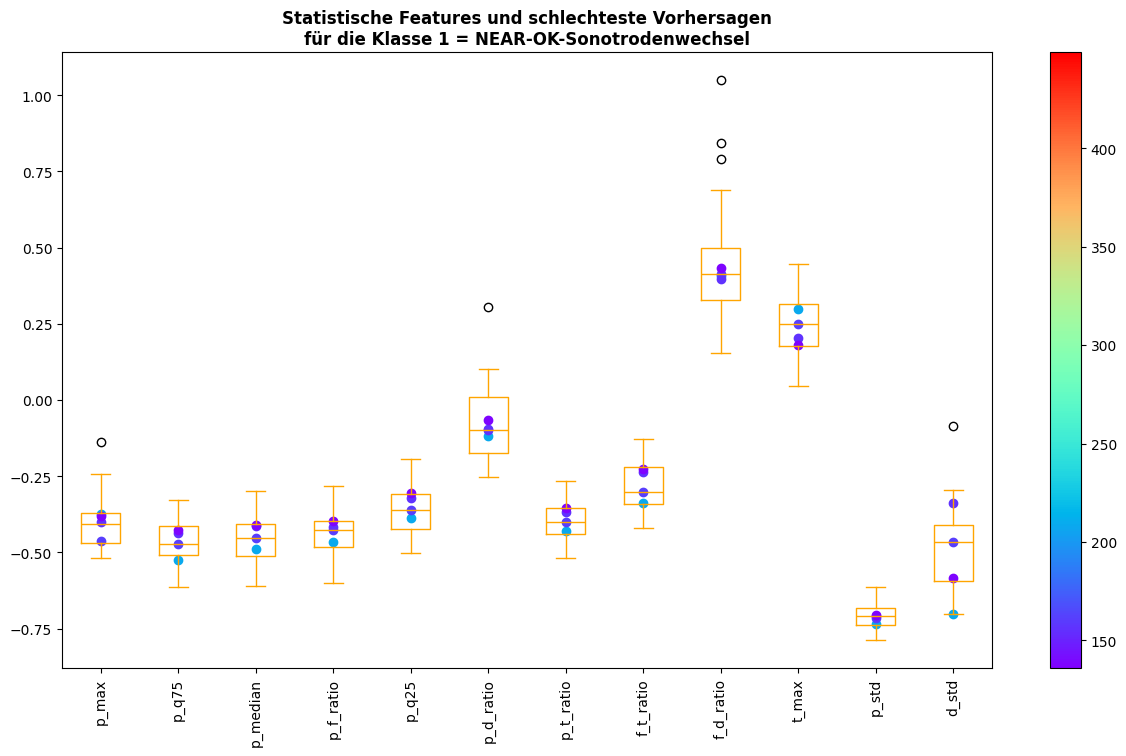

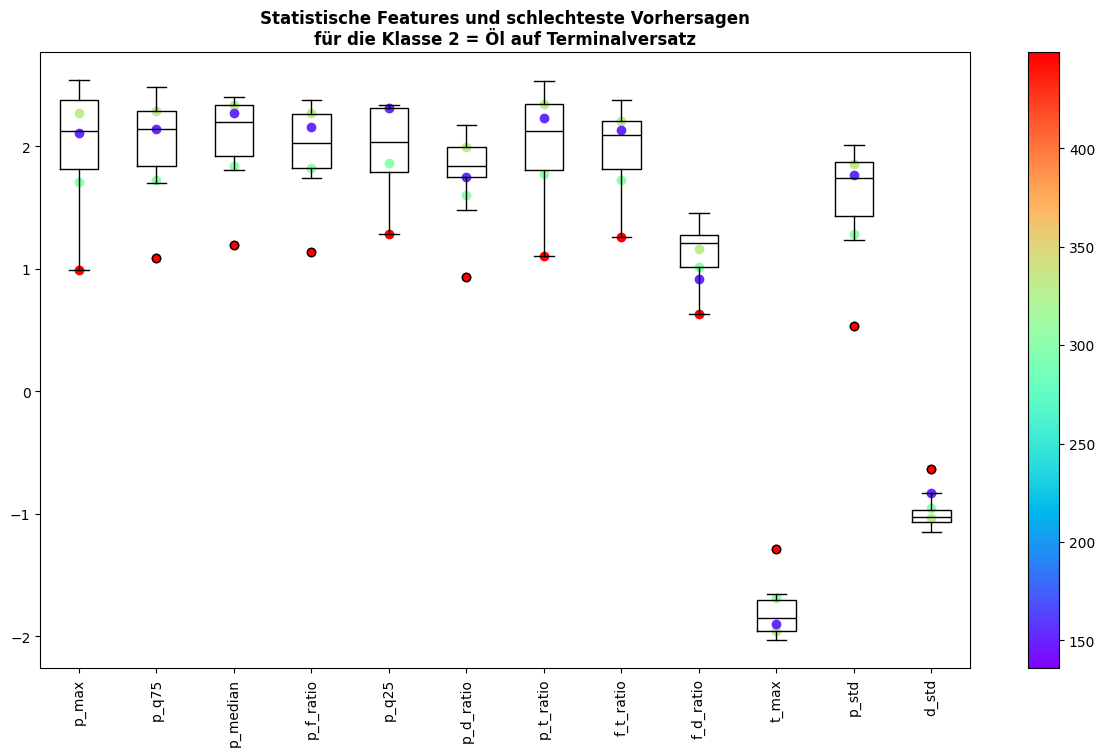

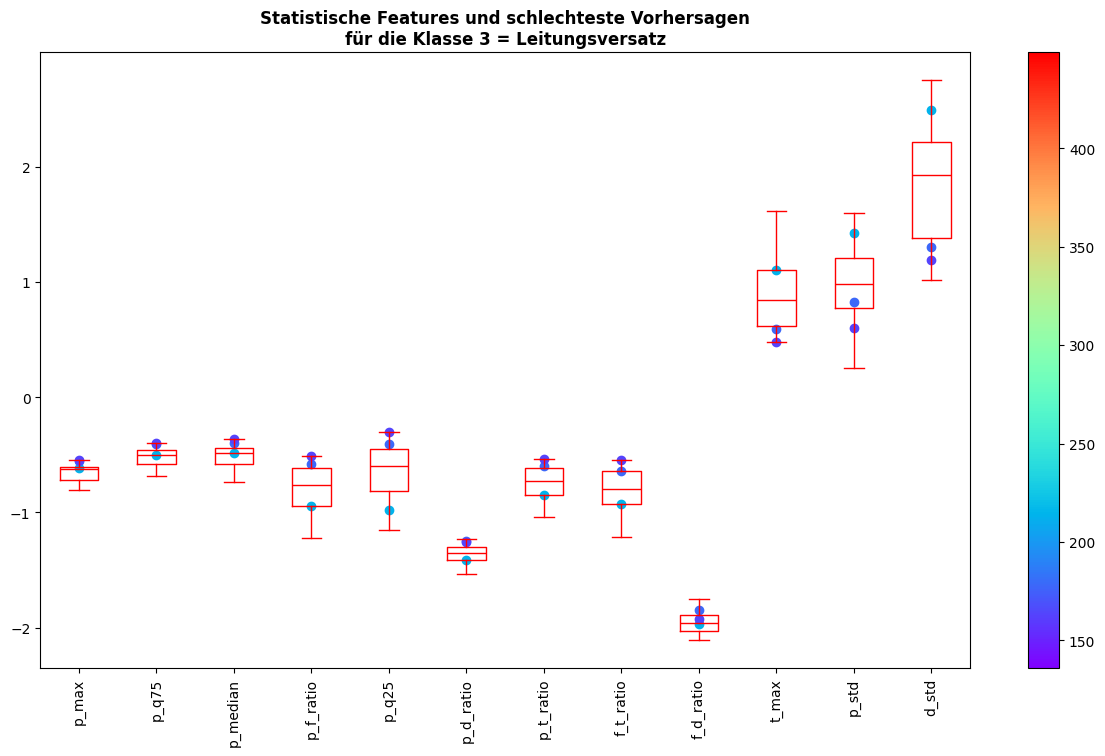

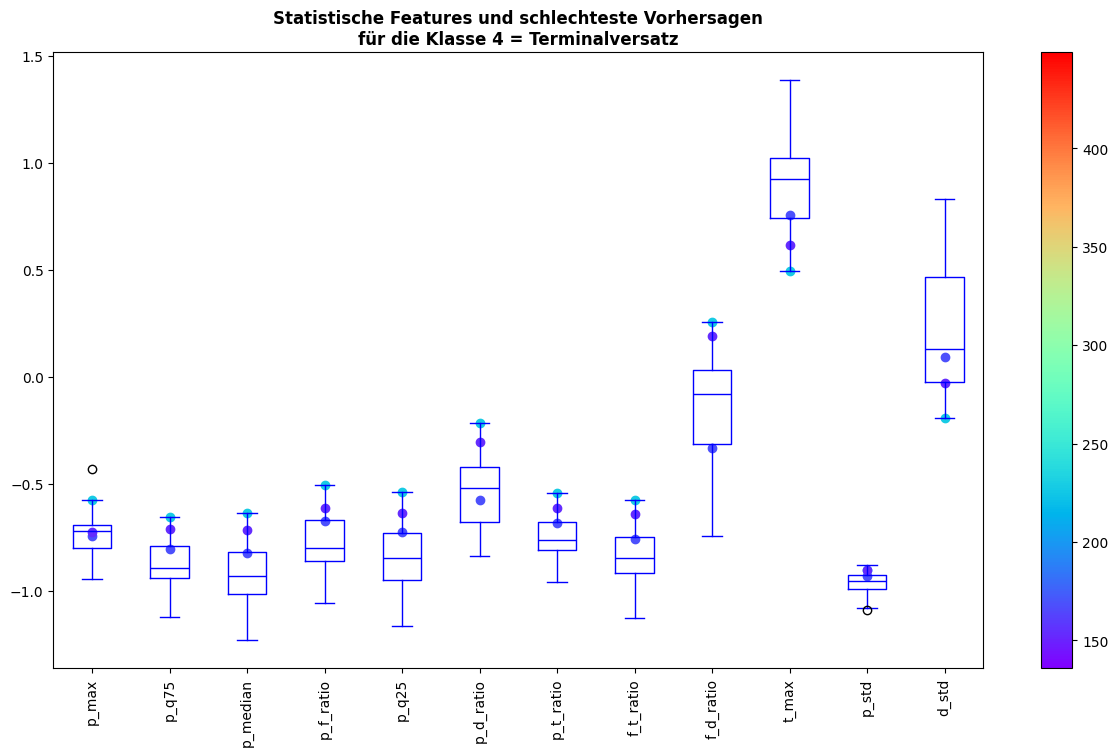

In [23]:
for label in range(5):
    boxplot_by_label(result_test, label, res_test_sorted.head(20))

= In welchen Klassen sind die Vorhersagen sehr schlecht bzw. sehr gut?                           
- abhängig von versch. Aufteilungen in Trainings- & Testdaten (random_state)                         

- Fehler gleichmäßig auf Klassen verteilt                                  

- größten Fehler bei Klasse 2 (Öl-Fehler) auf (rote Punkte) & die Features liegen hier meist außerhalb des Hauptbereiches (bei Power und Force gut zu sehen)